In [1]:
import os
import numpy as np
import torch
import nnsight
from nnsight import CONFIG
from grid import GridGraph
import matplotlib.pyplot as plt


# Set Access Keys
CONFIG.set_default_api_key("")
os.environ["HF_TOKEN"] = ""

/home/local_erictodd/.conda/envs/universal/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load Model
model_id = 'meta-llama/Meta-Llama-3.1-8B'
remote = False
# device = 'mps'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# 'mps' if torch.multiprocessing.is_mps_start_method() else 'cpu'
if remote:
    model = nnsight.LanguageModel(model_id, dispatch=False)
else:
    model = nnsight.LanguageModel(model_id, dispatch=True, device_map='cuda')

Loading checkpoint shards: 100%|██████████| 4/4 [00:09<00:00,  2.25s/it]


In [3]:
grid_node_names = [[' apple', ' bird', ' car', ' egg'],
                   [' house', ' milk', ' plane', ' opera'], 
                   [' box', ' sand', ' sun', ' mango'], 
                   [' rock', ' math', ' code', ' phone']] 

ring_names = [' apple', ' lettuce', ' grape', ' fig', ' carrot', ' pear', ' orange', ' onion', ' tomato', ' banana']
days_names = [' Mon', ' Tue', ' Wed', ' Thu', ' Fri', ' Sat', ' Sun']

In [4]:
# Create a 4x4 grid
grid = GridGraph(4)

# populate the grid with words
for i in range(4):
    for j in range(4):
        word = grid_node_names[i][j]
        grid.set_node_attributes((i,j), name=word, value=i*4+j)

In [45]:
N_STEPS = 1000
window_size = 200
random_walk = grid.random_walk(steps=N_STEPS)
str_walk = ''.join([x.name for x in random_walk])

token_set = [model.tokenizer(x).input_ids[-1] for x in list(grid.name_to_index.keys())]

token_walk = model.tokenizer(str_walk, return_tensors='pt').to(device)

In [46]:
LAYER = 26
with torch.no_grad(), model.trace(str_walk, remote=False) as tracer:
    out = model.model.layers[LAYER].output[0].save()

In [47]:
split_inds = {}
for i,t in enumerate(token_set):
    all_t = torch.where(token_walk.input_ids[0] == token_set[i])[0]
    split_inds[i] = torch.Tensor(list(filter(lambda x: x > N_STEPS - window_size, all_t))).long() # filter down to window size

In [48]:
H = torch.zeros(len(token_set), model.config.hidden_size)
h_t_stack = torch.cat([out[:,split_inds[i],:] for i in range(len(token_set))], dim=1)


for i,t in enumerate(token_set):
    h_t = out[:,split_inds[i],:]
    h_t_mean = h_t.mean(dim=1)
    H[i] = h_t_mean
    

# # PCA 
# U,S,Vh = torch.linalg.svd(H - H.mean(0))
# principal_components = Vh.T[:, :2] # columns of V are principal components (rows of Vh)

# PCA Projection of means and points:
projected_means = torch.matmul(H , principal_components)
projected_stack = torch.matmul(h_t_stack.cpu(), principal_components).squeeze()

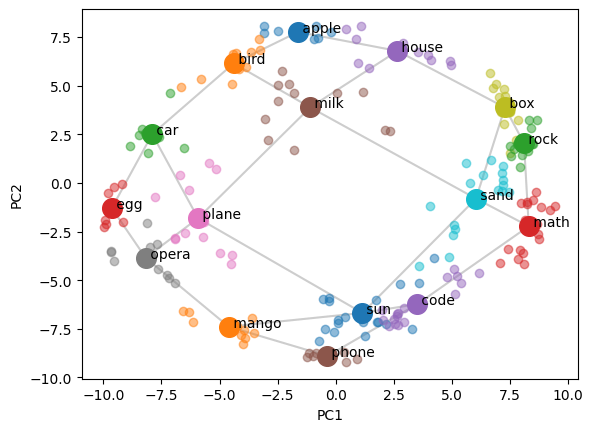

 apple  bird  car  egg
 house  milk  plane  opera
 box  sand  sun  mango
 rock  math  code  phone

In [49]:
num_points_per_node = [len(x) for x in split_inds.values()]

ranges = [sum(num_points_per_node[:i]) for i in range(17)]

for i in range(16):
    plt.scatter(projected_stack[ranges[i]:ranges[i+1],0], projected_stack[ranges[i]:ranges[i+1],1], color=f'C{i}', marker='o', alpha=0.5)
    plt.scatter(projected_means[i,0], projected_means[i,1], marker='o', color=f'C{i}', s=200)
    plt.text(projected_means[i,0], projected_means[i,1], grid.nodes[i].name)

for i in range(16):
    for j in range(16):
        if grid.adjacency_matrix[i][j] == 1:
            plt.plot([projected_means[i,0], projected_means[j,0]], [projected_means[i,1], projected_means[j,1]], color='black', alpha=0.1, zorder=0)
    


plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()
grid

In [51]:
str_walk

' bird car plane milk house milk house milk plane opera plane car plane opera plane milk house box rock math code math sand milk sand box rock math code math code phone code math code phone mango phone code phone code phone code phone mango sun code phone mango sun mango opera mango sun sand sun plane car bird apple house milk plane car egg opera plane opera plane sun sand milk house milk house apple house milk bird milk sand sun mango opera plane car plane milk house milk sand math rock box house milk plane milk house milk plane opera egg car plane car bird apple bird milk bird apple bird car plane opera egg opera plane milk plane car egg opera egg opera mango opera egg car plane milk plane milk plane car egg opera mango phone mango opera plane milk sand sun code phone mango phone mango opera plane opera plane milk plane car bird milk house box sand milk sand math rock math sand math code math sand milk house box house box house apple bird car bird apple house apple house box rock mat